# Обзор CNN

**Сверточная нейронна сеть (CNN)** - это модель, которая:
- применяет свёртки (Conv1D) к входным данным
- находит локальные паттерны и зависимости
- используется в задачах: изображений, текста и временных рядов

**Как CNN работает с временными рядами?**
- принимает на вход матрицу (дни $\times$ признаки)
- к ним применяются свертки, которые улавливают локальные шаблоны (например, рост/падение)
- используются для предсказания следующего значения, предсказания направления

**Какие преимущества у CNN для временных рядов?**
- улавливают локальные паттерны, сезонности, циклы
- быстро обучаются
- легко комбинируется с другими моделями (LSTM, например)

**Какие есть недостатки у CNN?**

- не запоминают глобальный контекст (нет долгосрочной памяти)
- зависит от длины окна (слишком маленькое - риск недообучения, слишком больше - риск переобучения)
- чувствительная к шуму

**Вывод:**
- CNN лучше всего подходит для краткосрочного прогноза


# Обзор данных

1. [Электропотребление](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/code?datasetId=122&sortBy=voteCount)

- ​Датасет "Household Electric Power Consumption" представляет собой набор данных с измерениями потребления электроэнергии в одном домохозяйстве с интервалом в одну минуту, охватывающий период почти 4 лет.

2. [Финансовые данные](https://disk.yandex.ru/d/_mRu33LR4xg94g)
- финансовый датасет с дневными данными (котировками акций Сбербанка) охватывает период около 3 лет



# Обзор используемых библиотек

In [ ]:
import pandas as pd

Работа с табличными данными (DataFrame) — чтение, фильтрация, преобразования

In [ ]:
import numpy as np

Работа с многомерными массивами и матрицами — численные операции.

In [ ]:
import matplotlib.pyplot as plt

Построение графиков и визуализация результатов.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Масштабирует данные в заданный диапазон (обычно [0, 1]). Это помогает ускорить обучение и избежать влияния разномасштабных признаков.

In [ ]:
from sklearn.model_selection import train_test_split

Способ разделить данные на обучающую и тестовую выборки

In [ ]:
from tensorflow.keras.models import Sequential

Позволяет строить модель как последовательность слоёв (без ветвлений).

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

Предоставляет слои для построения нейросетей.

In [ ]:
from tensorflow.keras.optimizers import Adam

Импорт популярного алгоритма оптимизации градиентного спуска в нейронных сетях

# Электропотребление (CNN)

**Цель:**
- Построить нейросетевую модель CNN для прогнозирования почасового электропотребления на основе временного окна в 168 часов (7 суток) на ~20 дней или на 500 часов

**План:**
- Загрузка и предобработка данных
- Создание временного окна
- Разделение на тренировочную и тестовую выборки
- Построение модели CNN
- Обучение модели на тренировочных данных
- Предсказание и сравнение с реальными значениями

1. **Загрузка и предобработка данных**

In [ ]:
# Загрузка данных
df = pd.read_csv("household_power_consumption.txt",
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df.set_index('datetime', inplace=True)
df = df.astype('float32')
df.dropna(inplace=True)

# Обозначение 'Global_active_power' как целевой признак
target_column = 'Global_active_power'
data = df[[target_column]]

# Нормализация
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Создание окон
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 168  # временное окно - 7 дней
X, y = create_sequences(scaled_data, window_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


<ipython-input-10-e6d930ef34a1>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt",
<ipython-input-10-e6d930ef34a1>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt",
<ipython-input-10-e6d930ef34a1>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt",


**2. Модель CNN**

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Один выход — скалярное значение

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 166, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 83, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 83, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5312)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         340,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 340,353 (1.30 MB)

 Trainable params: 340,353 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

**3. Обучение**

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - loss: 9.2113e-04 - val_loss: 5.9496e-04
Epoch 2/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 7.1630e-04 - val_loss: 6.0975e-04
Epoch 3/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 7.0380e-04 - val_loss: 6.0033e-04
Epoch 4/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - loss: 6.8175e-04 - val_loss: 5.6734e-04
Epoch 5/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 6.7812e-04 - val_loss: 5.7465e-04
Epoch 6/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 6.7566e-04 - val_loss: 6.1731e-04
Epoch 7/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 6.6689e-04 - val_loss: 5.9890e-04
Epoch 8/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 6.6536e-04 - val_loss: 5.6817e-04
Epoch 9/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 6.6054e-04 - val_loss: 5.6837e-04
Epoch 10/10
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 6.5301e-04 - val_loss: 5.8105e-04


**4. Оценка и визуализация**

In [ ]:
# Предсказания
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

12807/12807 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


In [ ]:
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

predictions = model.predict(X_test)

12807/12807 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 4.2167e-04
Test MSE: 0.0004093233437743038
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


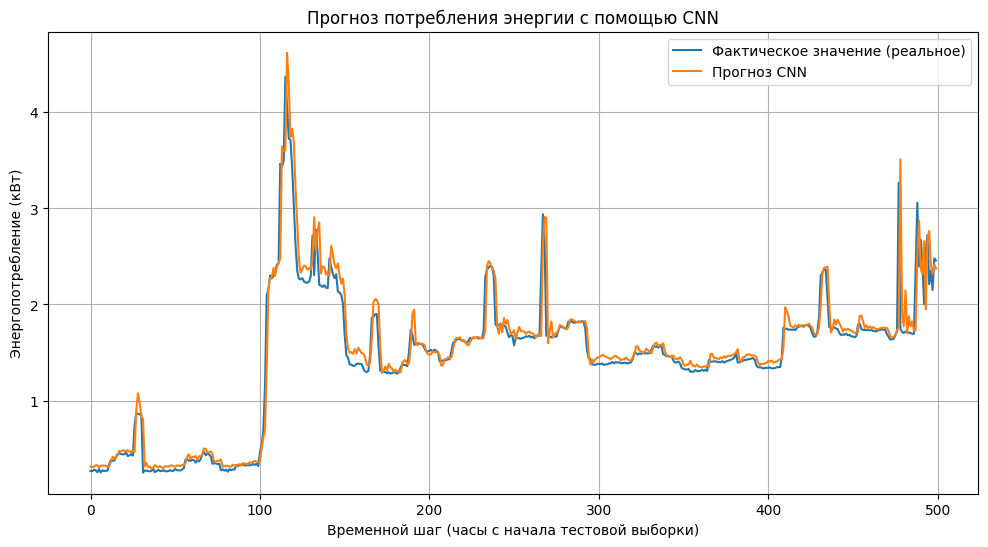

In [ ]:
# Визуализация
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:500], label='Фактическое значение (реальное)')
plt.plot(y_pred_inv[:500], label='Прогноз CNN')
plt.legend()
plt.title('Прогноз потребления энергии с помощью CNN')
plt.xlabel('Временной шаг (часы с начала тестовой выборки)')
plt.ylabel('Энергопотребление (кВт)')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv[:500], y_pred_inv[:500]))
print(f"RMSE: {rmse:.4f}")

# MAE
mae = mean_absolute_error(y_test_inv[:500], y_pred_inv[:500])
print(f"MAE: {mae:.4f}")

RMSE: 0.1954
MAE: 0.0945


# Финансовые данные (CNN)

**Цель:**

- Построить нейросетевую модель на основе сверточной сети (CNN) для прогнозирования дневной цены закрытия (close) акций, используя временное окно в 30 торговых дней, с горизонтом прогноза примерно на 200 дней.


**План:**
- Загрузка и предобработка данных
- Генерация временных окон
- Создание модели CNN
- Обучение
- Предсказание и визуализация


**1. Загрузка и подготовка данных**

In [ ]:
# Загрузка данных
df = pd.read_json('sber (1).json')
df.sort_values("date", inplace=True)
# df_features = df[['close', 'open', 'high', 'low', 'volume']].copy()
df_features = df[['close']].copy()

# Масштабирование
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features)

df_scaled = pd.DataFrame(df_scaled, columns=df_features.columns, index=df_features.index)

**2. Генерация окон**

In [ ]:
def make_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 30
dataset = df_scaled.values
X_all, y_all = make_sequences(dataset, window_size)

train_size = int(len(X_all)*0.7)
val_size = int(len(X_all)*0.1)

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_val = X_all[train_size : train_size + val_size]
y_val = y_all[train_size : train_size + val_size]

X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

**3. Модель CNN**

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, df_scaled.shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 28, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 12, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,041 (121.25 KB)

 Trainable params: 31,041 (121.25 KB)

 Non-trainable params: 0 (0.00 B)

**4. Обучение**

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.1309 - val_loss: 0.0059
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_

**5. Предсказания и визуализация**

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0016
Test MSE: 0.0018406473100185394
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
predictions_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

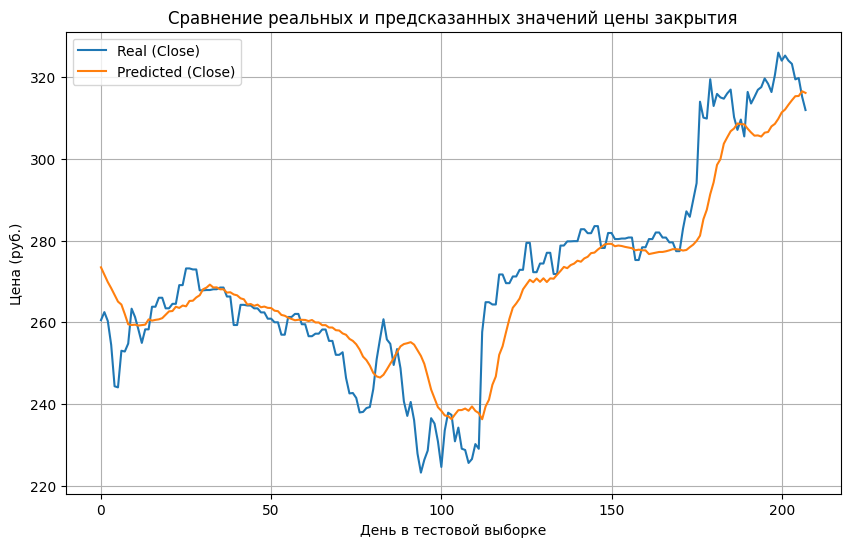

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Real (Close)')
plt.plot(predictions_unscaled, label='Predicted (Close)')
plt.title('Сравнение реальных и предсказанных значений цены закрытия')
plt.xlabel('День в тестовой выборке')
plt.ylabel('Цена (руб.)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(predictions_unscaled, y_test_unscaled))
print(f"RMSE: {rmse:.4f}")

# MAE
mae = mean_absolute_error(predictions_unscaled, y_test_unscaled)
print(f"MAE: {mae:.4f}")

RMSE: 9.7333
MAE: 7.1857


# Финансовые данные (бинарная классификация направления цены закрытия с помощью CNN)

**Цель:**

- На основе предыдущих 120 дней предсказать:
выросла ли цена close на следующий день или нет?

**План:**

- Создадим метку y = 1, если цена выросла, иначе 0
- Сформируем входные окна (X) и соответствующие метки (y)
- Построим CNN-классификатор
- Обучим модель
- Оценим точность (accuracy, precision, recall)
- Построим график real vs predicted ↑/↓

**1.  Создание метки up/down**

In [ ]:
# Используем 'close' как основу
close = df['close'].values

# 1, если цена выросла на следующий день, иначе 0
y_bin = np.where(close[1:] > close[:-1], 1, 0)

# Смещаем данные на 1, чтобы у нас было соответствие X и y
df_bin = df.iloc[:-1].copy()
df_bin['target'] = y_bin

**2. Масштабирование и формирование окон**

In [ ]:
features = ['close', 'open', 'low', 'high', 'volume', 'numtrades', 'trendclspr',
            'day_of_week', 'month', 'day_of_year']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_bin[features])
scaled_df = pd.DataFrame(scaled, columns=features)

target = df_bin['target'].values
window_size = 180

def create_classification_sequences(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size])
    return np.array(X), np.array(y)

X, y = create_classification_sequences(scaled_df.values, target, window_size)

X_train, X_test = X[:-10], X[-10:]
y_train, y_test = y[:-10], y[-10:]



**3. CNN-модель классификатор**

**CNN-классификатор** - это модель, которая получает последовательность и с помощью сверток (в нашем случае Conv1D) извлекает шаблоны: резкие падения, волны и т.д., выдавая вероятность раста цены на следующий день (через sigmoid).

Мы считаем, если выход $> 0.5$, то будет рост, иначе - падение.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Классификация
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 178, 64)             │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 5696)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │         364,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,657 (1.40 MB)

 Trainable params: 366,657 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

**4. Обучение**

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6226 - loss: 0.6851 - val_accuracy: 0.6023 - val_loss: 0.6696
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5975 - loss: 0.6730 - val_accuracy: 0.6023 - val_loss: 0.6853
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6327 - loss: 0.6480 - val_accuracy: 0.6023 - val_loss: 0.6738
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6388 - loss: 0.6395 - val_accuracy: 0.6023 - val_loss: 0.6815
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6441 - loss: 0.6288 - val_accuracy: 0.6023 - val_loss: 0.6772
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6842 - loss: 0.6193 - val_accuracy: 0.5909 - val_loss: 0.6720
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6765 - loss: 0.6120 - val_accuracy: 0.5341 - val_loss: 0.6858
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6946 - loss: 0.5934 - val_accuracy: 0.5341 - val_loss

**5. Оценка**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
              precision    recall  f1-score   support

        Down       0.67      0.67      0.67         6
          Up       0.50      0.50      0.50         4

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10



**6. Визуализация сигналов**

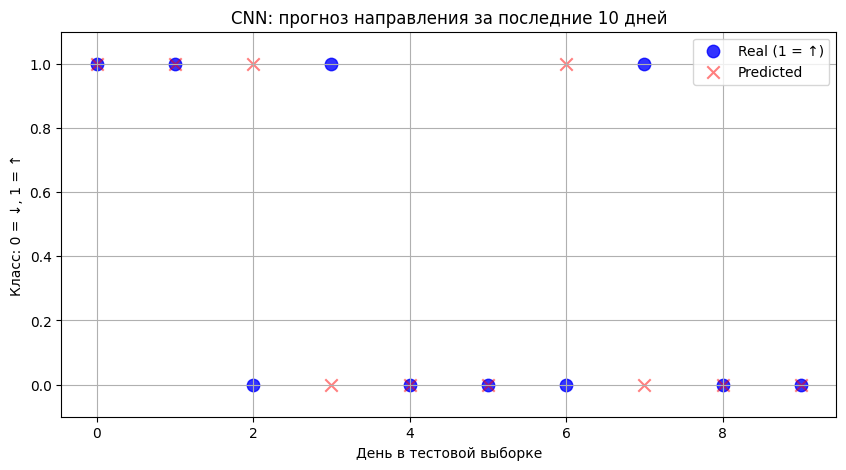

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(range(10), y_test, label='Real (1 = ↑)', color='blue', s=80, alpha=0.8)
plt.scatter(range(10), y_pred, label='Predicted', color='red', s=80, alpha=0.5, marker='x')
plt.ylim(-0.1, 1.1)
plt.title('CNN: прогноз направления за последние 10 дней')
plt.xlabel('День в тестовой выборке')
plt.ylabel('Класс: 0 = ↓, 1 = ↑')
plt.legend()
plt.grid(True)
plt.show()

Вывод: точность 60%

# Hybrid CNN-LSTM (Электропотребление)

In [ ]:
# Загрузка данных
df = pd.read_csv("household_power_consumption.txt", sep=';',
                 parse_dates={'dt': ['Date', 'Time']},
                 infer_datetime_format=True, na_values=['?', 'nan'], low_memory=False)
df.head()

<ipython-input-74-4664f8e91912>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=';',
<ipython-input-74-4664f8e91912>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt", sep=';',
<ipython-input-74-4664f8e91912>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt", sep=';',


,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   dt                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
# Обработка данных

df.dropna(inplace=True)
df.set_index('dt', inplace=True)
df_resampled = df.resample('H').mean().interpolate()
target_col = 'Global_active_power'
df_resampled.head()

<ipython-input-76-8f5dc5c6b90e>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').mean().interpolate()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [ ]:
data_values = df_resampled[[target_col]].values

# Масштабирование
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_values)

# Создание окон

def create_sequences(dataset, window_size=24):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        seq_x = dataset[i : i + window_size]
        seq_y = dataset[i + window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size)

In [ ]:
# Разделение на train/test
train_val_size = int(len(X)*0.9)
X_train_val, y_train_val = X[:train_val_size], y[:train_val_size]
X_test, y_test = X[train_val_size:], y[train_val_size:]
train_split = int(len(X) * 0.8)
X_train, y_train = X_train_val[:train_split], y_train_val[:train_split]
X_val, y_val = X_train_val[train_split:], y_train_val[train_split:]

# Гибридная модель CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 20, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,697 (178.50 KB)

 Trainable params: 45,697 (178.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение
model.fit(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_val, y_val), shuffle=False)

Epoch 1/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0190 - val_loss: 0.0083
Epoch 2/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 3/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0115 - val_loss: 0.0094
Epoch 4/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 5/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 6/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 7/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 8/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 9/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 10/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0104 - val_loss: 0.0078


In [ ]:
# Прогноз
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Оценка
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_pred, y_true)
rmse = np.sqrt(mean_squared_error(y_pred, y_true))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.26
RMSE: 0.34


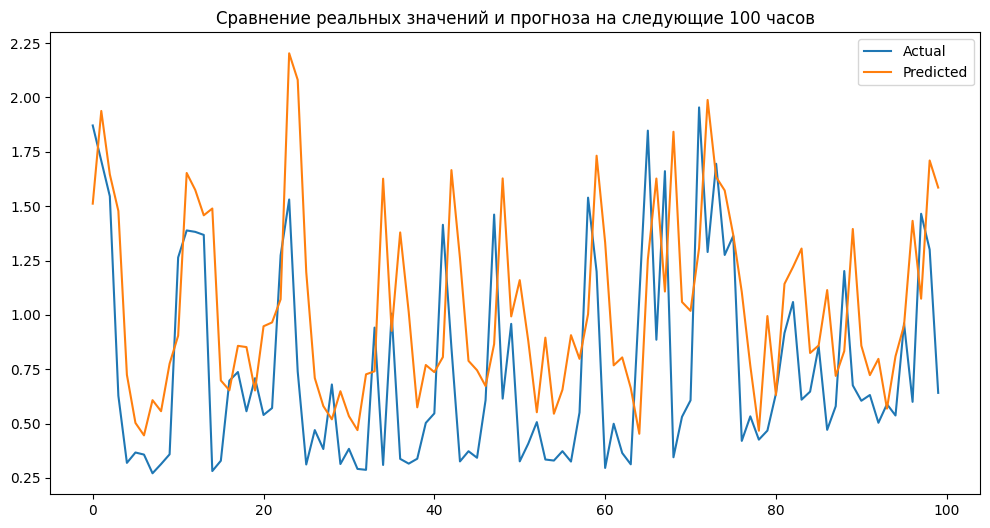

In [ ]:
# Визуализация
plt.figure(figsize=(12,6))
plt.plot(y_true[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Сравнение реальных значений и прогноза на следующие 100 часов')
plt.legend()
plt.show()

# Hybrid CNN-LSTM (Финансовые данные)

In [ ]:
# Загрузка и обработка данных

df = pd.read_json('sber (1).json')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.sort_values('date', inplace=True)
df = df.drop_duplicates()
df.set_index('date', inplace=True)
df_model = df[['close', 'open']].copy()
df_model.dropna(inplace=True)

df_model.head()

,close,open
date,,
2022-03-28,125.00,130.60
2022-03-29,128.77,126.16
2022-03-30,134.60,136.89
2022-03-31,143.69,135.25
2022-04-01,154.50,145.00


In [ ]:
# Масштабирование данных

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_model.values)

# Переведём обратно в DataFrame
df_model_scaled = pd.DataFrame(scaled_values, columns=['close','open'])

# Создание окон
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_X = data[i : i + window_size]
        next_close = data[i + window_size, 0]
        X.append(seq_X)
        y.append(next_close)
    return np.array(X), np.array(y)

window_size = 30
X_all, y_all = create_sequences(df_model_scaled.values, window_size=window_size)


In [ ]:
# Разделение на train/val/test

train_size = int(len(X_all)*0.8)
val_size = int(len(X_all)*0.9)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_val = X_all[train_size:val_size]
y_val = y_all[train_size:val_size]
X_test = X_all[train_size:]
y_test = y_all[train_size:]

# Построение гибридной модели CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                        input_shape=(window_size, 2)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 28, 64)              │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 26, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,889 (179.25 KB)

 Trainable params: 45,889 (179.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0079
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

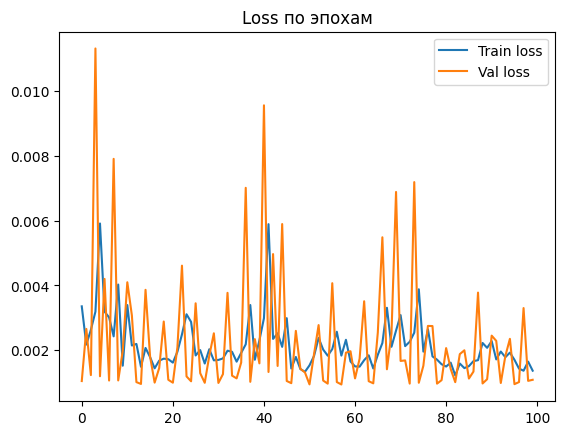

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False
)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss по эпохам")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 7.28
RMSE: 9.32


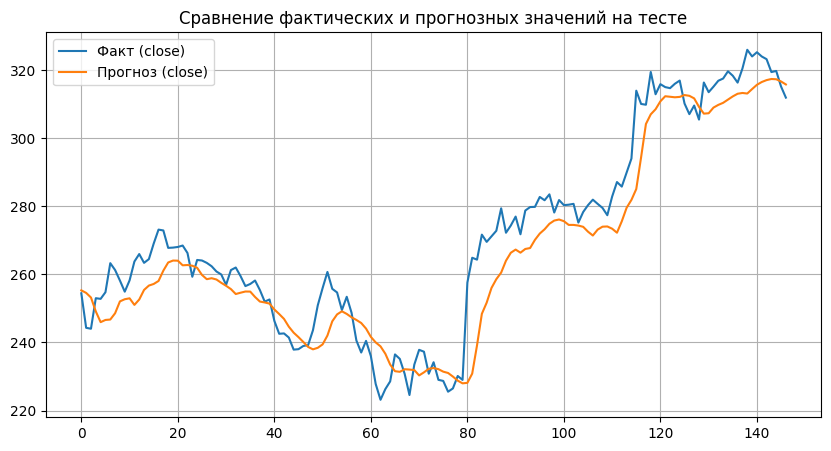

In [ ]:
y_pred_scaled = model.predict(X_test)
temp_pred = np.zeros((len(y_pred_scaled), 2))
temp_pred[:,0] = y_pred_scaled[:,0]  # заполняем close

y_pred = scaler.inverse_transform(temp_pred)[:,0]  # возвращаем только close

# Аналогично для y_test
temp_test = np.zeros((len(y_test), 2))
temp_test[:,0] = y_test

y_test_true = scaler.inverse_transform(temp_test)[:,0]

# Оценка
mae = mean_absolute_error(y_pred, y_test_true)
rmse = np.sqrt(mean_squared_error(y_pred, y_test_true))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Сравним визуально
plt.figure(figsize=(10,5))
plt.plot(y_test_true, label='Факт (close)')
plt.plot(y_pred, label='Прогноз (close)')
plt.title("Сравнение фактических и прогнозных значений на тесте")
plt.legend()
plt.grid(True)
plt.show()
